# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [40]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

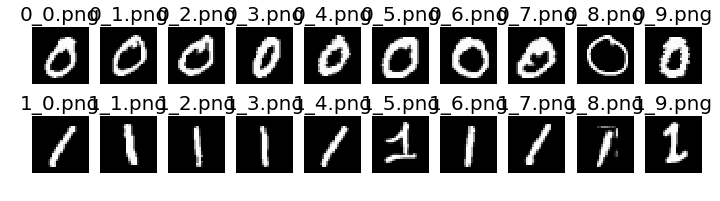

In [41]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import find_contours,label,regionprops
from skimage.filters import threshold_otsu


%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [42]:
#Standard config:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 'xx-large'

### 1.2 Fourier descriptors
Add your implementation and discussion

In [50]:
def get_longest_contour(contours):
    """Select the biggest contour which assures we used the outside part of zeros and avoid contamination of noise like in the 8th ones"""
    max_c = contours[0]
    for c in contours:
        if len(c) > len(max_c):
            max_c = c
            
    return max_c

In [46]:
def get_fourier_descr(image):
    """ Get amplitude of the first four Fourier descriptor of an image """
    """Inputs : The image to analyse
       Output : amplitude of the first four Fourier descriptor ."""
    thresh = threshold_otsu(image)
    imthresh = (image < thresh)
    contours = find_contours(imthresh,0)
    max_contour = get_longest_contour(contours)
    contour_complex = np.empty(max_contour.shape[0], dtype=complex)
    contour_complex.real = max_contour[:, 0]
    contour_complex.imag = max_contour[:, 1]
    fourier_result = np.fft.fft(contour_complex)
    return fourier_result[:4]

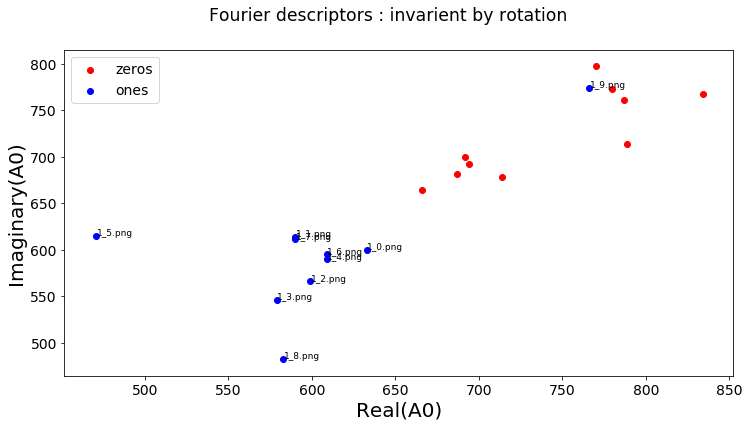

In [47]:
for im in zeros_im:
    descpr = get_fourier_descr(im)
    A1 = descpr[0].real
    A2 = descpr[0].imag
    zero = plt.scatter(A1,A2,c='red')
for im, name in zip (ones_im, ones_names):
    descpr = get_fourier_descr(im)
    A1 = descpr[0].real
    A2 = descpr[0].imag
    one = plt.scatter(A1,A2,c='blue')
    plt.text(A1+0.3, A2+0.3, name, fontsize=9)
plt.suptitle("Fourier descriptors : invarient by rotation")
plt.xlabel('Real(A0)')
plt.ylabel('Imaginary(A0)');
plt.legend((zero,one),('zeros','ones'))



#### Observation
Using the first Fourier descriptor, plotting on the real over imaginary part of it. Here data of the two classes are melted together suggesting that the first Fourier descriptor is not a good discriminator by itself.

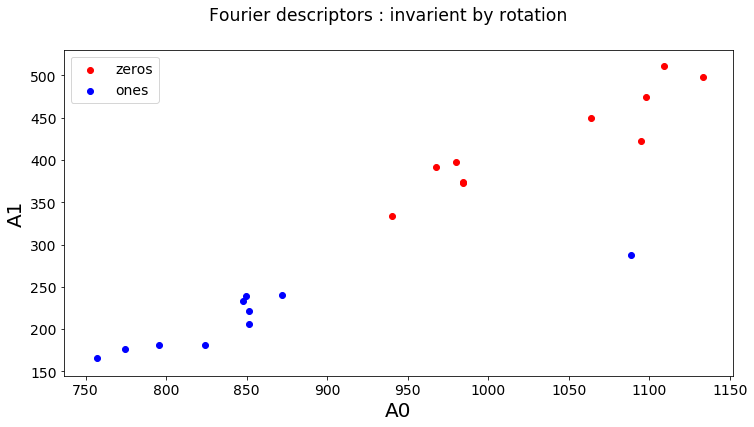

In [48]:
for im in zeros_im:
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[0])
    A2 = abs(descpr[1])
    zero = plt.scatter(A1,A2,c='red')
for im in ones_im:
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[0])
    A2 = abs(descpr[1])
    one = plt.scatter(A1,A2,c='blue')
plt.suptitle("Fourier descriptors : invarient by rotation")
plt.xlabel('A0')
plt.ylabel('A1');
plt.legend((zero,one),('zeros','ones'))



#### Observation
Here we plot only the amplitudes of the two first descriptor and therefore have invariance in rotation. It also means that we don't need to worry about the starting point chosen to compute the contour of the object. We see that two clusters appears and that we found well discrinimating features. There is one outlier in the images of Ones, which we can identify :  

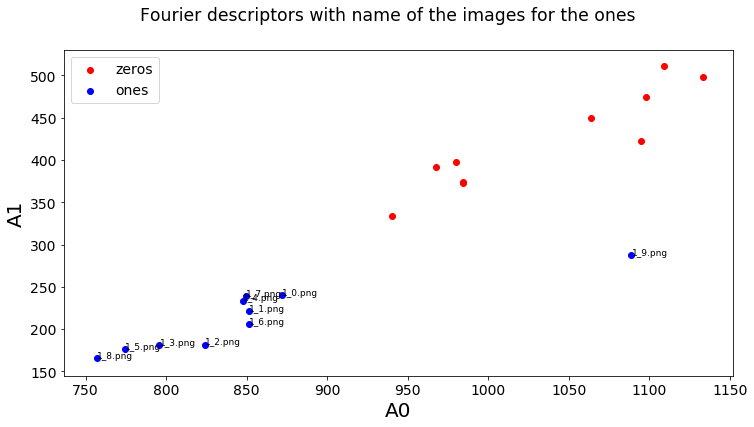

In [49]:
for im in zeros_im:
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[0])
    A2 = abs(descpr[1])
    zero = plt.scatter(A1,A2,c='red')
for im, name in zip (ones_im, ones_names):
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[0])
    A2 = abs(descpr[1])
    one = plt.scatter(A1,A2,c='blue')
    plt.text(A1+.03, A2+.03,name, fontsize=9)
plt.suptitle("Fourier descriptors with name of the images for the ones")
plt.xlabel('A0')
plt.ylabel('A1');
plt.legend((zero,one),('zeros','ones'))


#### Observation
We see that the outlier correspond to the 9th image which is indeed quite different. 

In [1]:
for im in zeros_im:
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[1])/abs(descpr[0])
    A2 = abs(descpr[2])/abs(descpr[0])
    zero = plt.scatter(A1,A2,c='red')
for im in ones_im:
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[1])/abs(descpr[0])
    A2 = abs(descpr[2])/abs(descpr[0])
    one = plt.scatter(A1,A2,c='blue')
plt.suptitle("Fourier descriptors : invarient by rotation and scaling")
plt.xlabel('A1/A0')
plt.ylabel('A2/A0');
plt.legend((zero,one),('zeros','ones'))

NameError: name 'zeros_im' is not defined

#### Observation
Adding invariance to scaling gives even more discernable clusters. This is in line with the observation that ones and zeros have quite different size amongst the same class. 

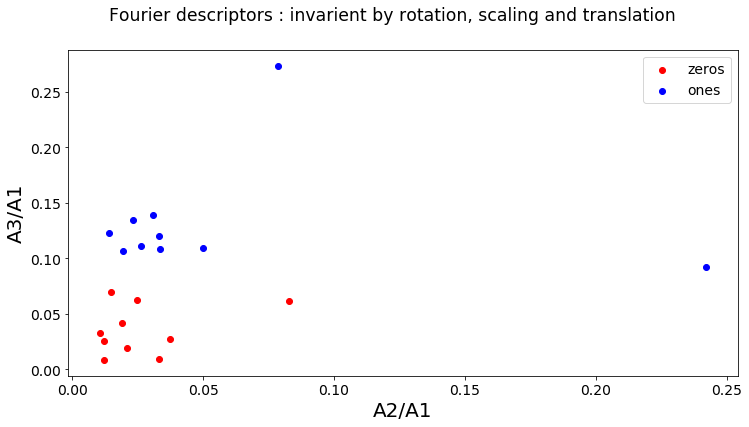

In [51]:
for im in zeros_im:
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[2])/abs(descpr[1])
    A2 = abs(descpr[3])/abs(descpr[1])
    zero = plt.scatter(A1,A2,c='red')
for im in ones_im:
    descpr = get_fourier_descr(im)
    A1 = abs(descpr[2])/abs(descpr[1])
    A2 = abs(descpr[3])/abs(descpr[1])
    one = plt.scatter(A1,A2,c='blue')
plt.suptitle("Fourier descriptors : invarient by rotation, scaling and translation")
plt.xlabel('A2/A1')
plt.ylabel('A3/A1');
plt.legend((zero,one),('zeros','ones'))

#### Observation
Adding invarience to translation does not seem to improve the results so much, suggesting that image are more or less in the same place on each image.

### 1.3 Additional method(s)
Add your implementation and discussion

In [52]:
def biggest_label(props):
    """Gets the prop of the biggest label : this is mainly used to be resistant to noise such as in the 8th"""
    max_lab = props[0]
    for lab in props:
        if lab.area > max_lab.area:
            max_lab = lab
    return max_lab

In [23]:
def holes(image):
    """ Get amplitude of the first four Fourier descriptor of an image """
    """Inputs : The image to analyse
       Output : amplitude of the first four Fourier descriptor ."""
    thresh = threshold_otsu(image)
    imthresh = (im > thresh) 
    labls = label(imthresh, 8)
    prop = biggest_label(regionprops(labls))
    size_hole = prop.filled_area
    size_object = prop.area
    return (size_hole, size_object)

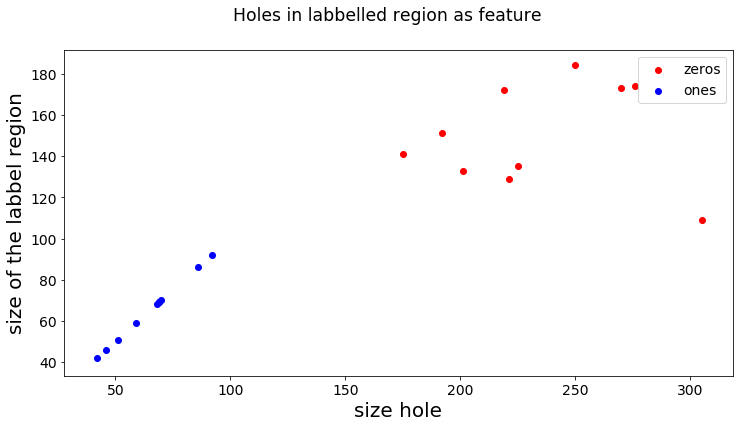

In [24]:
for im in zeros_im:
    (hole,obj) = holes(im)
    zero = plt.scatter(hole,obj,c='red')
for im in ones_im :
    (hole,obj) = holes(im)
    if(hole==3 & obj==3):
        one = plt.scatter(hole,obj, c='blue')
    else:
        one = plt.scatter(hole,obj,c='blue')
plt.suptitle("Holes in labbelled region as feature")
plt.xlabel('size hole')
plt.ylabel('size of the labbel region');
plt.legend((zero,one),('zeros','ones'))

#### Observation 
Here we used the fact that a labbel of a shape 0 will have a big whole in the middle which is not the case with a object of shape 1. We therefore use the size of the filled area (the area of the holes in the labbeled area) and the size of the area itself as features We see that it is a good feature to differentiate 0s and 1s. We see that the ones have much lower size of hole which is consistent with what we assumed when we selected this criteria as a feature.

## Area versus convex_area

In [25]:
def polygone_area(image):
    thresh = threshold_otsu(image)
    imthresh = (image > thresh) 
    labls = label(imthresh, 8)
    prop = biggest_label(regionprops(labls))
    size_polygone = prop.convex_area
    size_object = prop.area
    return(size_object, size_polygone)

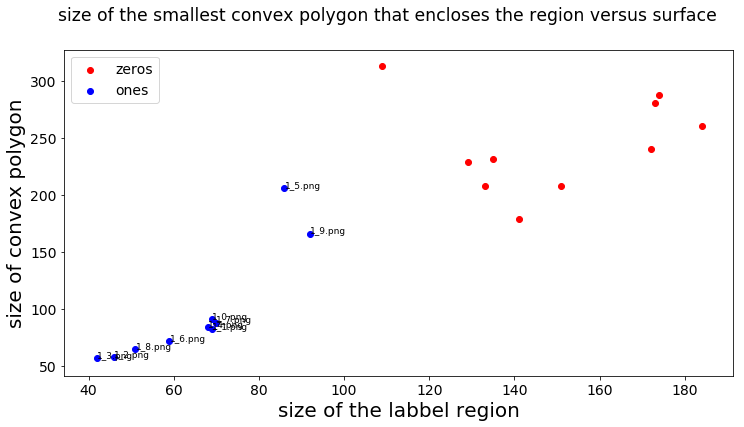

In [26]:
for im in zeros_im:
    (pol,obj) = polygone_area(im)
    zero = plt.scatter(pol,obj,c='red')
for im, name in zip (ones_im, ones_names) :
    (pol,obj) = polygone_area(im)
    one = plt.scatter(pol,obj,c='blue')
    plt.text(pol+.03, obj+.03,name, fontsize=9)
plt.suptitle("size of the smallest convex polygon that encloses the region versus surface")
plt.xlabel('size of the labbel region')
plt.ylabel('size of convex polygon');
plt.legend((zero,one),('zeros','ones'))

### Observation:

In this case we used the fact that like in the previous example, size of the labbel region is well differenciated between Zeros and Ones. Plus, the size of the smallest convex polygon that encloses the region is much higher in the Zeros than in the Ones.

## Area vs Perimeter

In [20]:
def perimeter_area(img):
    thresh = threshold_otsu(img)
    imthresh = (im > thresh) 
    labls = label(imthresh, 8)
    prop = biggest_label(regionprops(labls))
    perimeter = prop.perimeter
    size_object = prop.area
    return(perimeter, size_object)

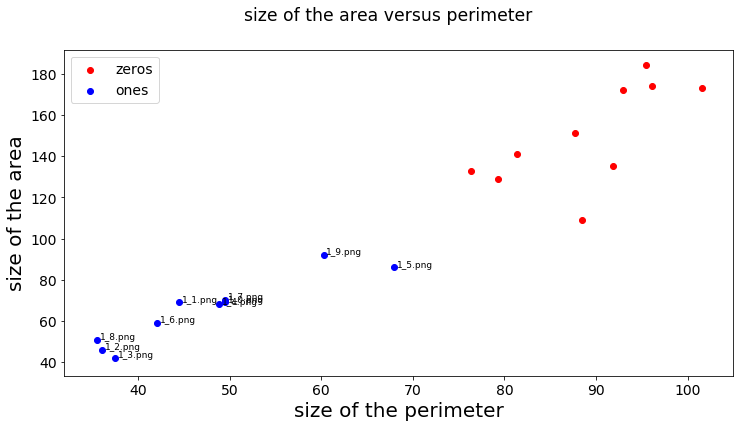

In [21]:
for im in zeros_im:
    (peri,obj) = perimeter_area(im)
    zero = plt.scatter(peri,obj,c='red')
for im, name in zip (ones_im, ones_names) :
    (peri,obj) = perimeter_area(im)
    one = plt.scatter(peri,obj,c='blue')
    plt.text(peri+0.3, obj+0.3, name, fontsize=9)
plt.suptitle("size of the area versus perimeter")
plt.xlabel('size of the perimeter')
plt.ylabel('size of the area');
plt.legend((zero,one),('zeros','ones'))

### Observations:

Here the descriptors seem to be good enough to split the clusters well. Indeed the aera of the zero as well as the perimeter is greater than for the ones and we could a linear split for both these features.

## Compacity vs Elongation

In [29]:
def compacity_elongation(img):
    thresh = threshold_otsu(img)
    imthresh = (img > thresh) 
    labls = label(imthresh, 8)
    prop = biggest_label(regionprops(labls))
    perimeter = prop.perimeter
    area = prop.area
    elongation = perimeter ** 2 / area
    max_diameter = max([prop.minor_axis_length, prop.major_axis_length])
    min_diameter = min([prop.minor_axis_length, prop.major_axis_length])
    small_number = 1e-1
    return(elongation, max_diameter/min_diameter) if min_diameter != 0 else (elongation, max_diameter/small_number)

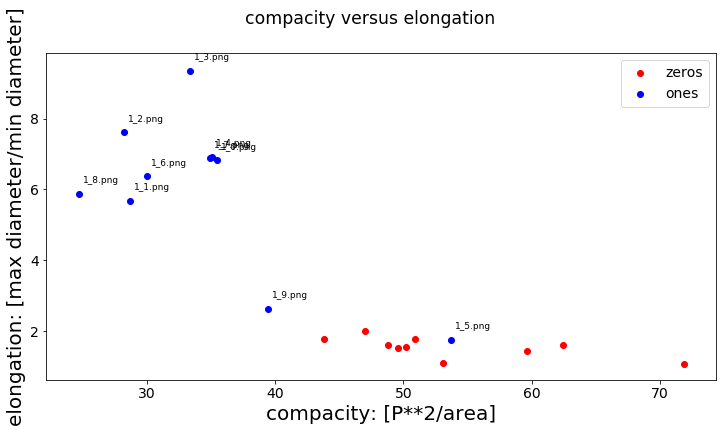

In [30]:
for im in zeros_im:
    (comp, ratio) = compacity_elongation(im)
    zero = plt.scatter(comp,ratio,c='red')
for im, name in zip (ones_im, ones_names) :
    (comp,ratio) = compacity_elongation(im)
    one = plt.scatter(comp,ratio,c='blue')
    plt.text(comp+0.3, ratio+0.3, name, fontsize=9)
plt.suptitle("compacity versus elongation")
plt.xlabel('compacity: [P**2/area]')
plt.ylabel('elongation: [max diameter/min diameter]');
plt.legend((zero,one),('zeros','ones'))

### Observation:
Here, we get one outlier in the ones images: the 5th image of the ones seem to be described by the same values that zeros are. 
This means that this pair of descriptors are not good at discriminating the two types of shape. 

## Conclusion:

As seen in the various methods tested, there is many possibilities to describe the digits images. However some descriptors can descriminate 0 digits from 1 digits (holes, area vs perimeter, area vs convex_area, ...) and other cannot (compacity vs elongation, first fourier descriptors).

What is interesting to notice is the fact that when descriptors cannot descriminate the digits it's either due to 1-9 or 1-5. In fact this is due to the special shape of the latter ones digits, they both have a baseline where other don't.